# How much does an Uber driver earn?
-Taylor Walraven

I drove for Uber from June 2019 right up until the president declared a national emergency. For my own safety, I elected to stop. I was fortunate to have worked a nearly-full-time job through September 2019, so I was approved for unemployment without delay after the CARES Act was passed. The money from "regular" unemployment, supplemented by pandemic unemployment assistance has enabled me to work on data science / analysis projects while searching for a job in data.

In March, Uber offered 2 weeks pay if drivers produced a doctor's note recommending they self-isolate. I did this and was compensated $583.80 a few weeks after submitting documentation. These payments were reported to be an amount nearly equivalent to two weeks of pay determined by the past 6 months of driving, but later it was announced that different markets had maximum amounts paid. 

Houston, Texas, I felt, was a pretty good market for rideshare. I felt that the amount I was capable of earning as an Uber driver was a suitable one for the work I was doing. However, I wondered if $583.80 really was two weeks' worth of earnings or if it was capped by the market maximum amount. I figured I could use data analysis to find out for sure. Not only that, but I could know definitively the answer to an extremely common question: "How much do you make?" 

I'll use these tools in my analysis:

In [1]:
#imports 
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import datetime as dt

## Data Collection

First, I needed to acquire the data for my trips. Uber makes this fairly simple. Log in to drivers.uber.com in a web browser and, after going through 2-factor authentication, one can view his earnings statements or download them as csv files. An earnings statement is generated once for every cash-out transaction, whether it is initiated at-will by the driver, or automatically at approximately 4 AM on Monday morning.

# TODO: 
# 1. Automate the process of downloading the csv files from the Uber website
# 2. Create an anonymous id unique to each driver

In [2]:
#get file names from data directory
months = !ls data/earnings
files = []
for i in np.arange(0,len(months)):
    file_list = !ls data/earnings/{months[i]}
    for filename in file_list:
        files.append(f'data/earnings/{months[i]}/{filename}')

## Data Transformation

Data almost always must be reformatted or transformed in preparation for its application or analysis. I'll take a few steps to do this below and provide some explanation.

In [3]:
def trim_columns(df):
    #remove extraneous columns, including those with 0 non-null values
    return df.drop(columns=['Driver Name', 'Phone Number', 'Email', 
                       'Other Promotions', 'Instant Pay Fees',
                       'Quest Promotion', 'Flex Pay Fee',
                       'Consecutive Trips Promotion'])

In [4]:
def make_numeric(df):
    #remove dollar signs from text and change to numbers (floats are best for currency)
    for col in df.columns[np.arange(3, len(df.columns))]:
        df[col] = df[col].str.replace("$","").astype(float)

    #set all NaN's to zero
    return df.fillna(0)

In [5]:
def combine_tips(df):
    #check for trip id's that appear on more than 1 row and assemble a list of them
    counts = df['Trip ID'].value_counts() > 1
    multirow_ids = list(counts.loc[counts == True].index)

    #rows with matching trip ids can be added together; sometimes a tip is paid separately
    combined_trips = []
    for trip_id in multirow_ids:
        combined_trips.append(df.loc[df['Trip ID'] == trip_id].sum())

    #summing text fields as above combines them, so we'll lop off the second halves
    for trip in range(0,len(combined_trips)):
        for col in range(0,3): #trip id, date/time, and type
            field_length = int(len(combined_trips[trip][col])/2)
            new_val = combined_trips[trip][col][0:field_length]
            combined_trips[trip][col] = new_val

    #create a dataframe of our newly combined trip rows
    tips_df = pd.DataFrame(data=combined_trips)

    #Trip ID is an effective index, we'll use it to make room for our tipped trips
    df.set_index('Trip ID', inplace=True)
    df.drop(labels=multirow_ids, inplace=True)

    #combine tipped and non-tipped
    tips_df.set_index('Trip ID', inplace=True)
    return pd.concat([df,tips_df])

In [6]:
def format_dates(df):
    #convert to datetime objects
    df['Date/Time'] = pd.to_datetime(df['Date/Time'])
    return df

In [7]:
def transform_data(df):
    #combine the above functions into one
    return format_dates(combine_tips(make_numeric(trim_columns(df))))

In [8]:
#read and transform trip data
print(dt.datetime.now())
trips_df = transform_data(pd.concat([pd.read_csv(file) for file in files]))
print(dt.datetime.now())

2020-08-08 21:22:30.499511
2020-08-08 21:22:32.445867


In [9]:
trips_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1113 entries, 9fad003a-9907-496a-8cf3-5c1d0fe7a8d9 to 20969ca1-065e-4a99-b17c-f760e243c69a
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Date/Time            1113 non-null   datetime64[ns]
 1   Type                 1113 non-null   object        
 2   Base Fare            1113 non-null   float64       
 3   Distance             1113 non-null   float64       
 4   Time                 1113 non-null   float64       
 5   Min Fare Supplement  1113 non-null   float64       
 6   Pickup Fee           1113 non-null   float64       
 7   Dropoff Fee          1113 non-null   float64       
 8   Tip                  1113 non-null   float64       
 9   Optional Insurance   1113 non-null   float64       
 10  Total                1113 non-null   float64       
 11  Toll                 1113 non-null   float64       
 12  Wait Time            1113 no

In [10]:
trips_df.tail()

,Date/Time,Type,Base Fare,Distance,Time,Min Fare Supplement,Pickup Fee,Dropoff Fee,Tip,Optional Insurance,Total,Toll,Wait Time,Cancellation,Surge,Boost,Long Pickup Fee,Share Adjustment,Fare Adjustment
Trip ID,,,,,,,,,,,,,,,,,,,
79c24305-0d20-48bb-941a-0d623ddb1d4b,2020-01-17 23:00:00,UberX,0.75,1.06,0.76,0.0,0.00,0.00,3.0,-0.07,5.50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
b9c31c45-63a1-455a-b423-52bdddbf8684,2019-12-10 23:29:00,UberX,0.75,1.58,1.13,0.0,0.00,0.00,1.0,-0.10,4.36,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
490162f5-99a7-4277-ba0e-8c07af120d78,2019-06-11 19:46:00,UberX,0.75,2.24,1.61,0.0,0.00,0.00,1.0,-0.14,5.46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10d1fdef-b454-4c40-bc9e-9bb47c17d5be,2019-09-17 18:52:00,Delivery,0.00,6.03,2.73,0.0,1.12,0.75,4.0,-0.43,17.60,3.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20969ca1-065e-4a99-b17c-f760e243c69a,2019-08-03 21:59:00,UberX,0.75,5.91,2.23,0.0,0.00,0.00,1.0,-0.37,9.82,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0


# Data Analysis

In [11]:
#see how close uber came to the announced 2 weeks of average-over-the-last-6-months pay
last_six = trips_df.loc[trips_df['Date/Time'] > '2019-09-13']
six_x = last_six.groupby(last_six['Date/Time'].dt.isocalendar().week)
six_y = six_x['Total'].sum()
est = round(six_y.mean()*2, 2)
aid = 583.80
print(f'{aid} - {est} = {round(aid-est,2)} :: {round(100-(aid/est*100),2)}% off. Not bad.')

583.8 - 615.42 = -31.62 :: 5.14% off. Not bad.


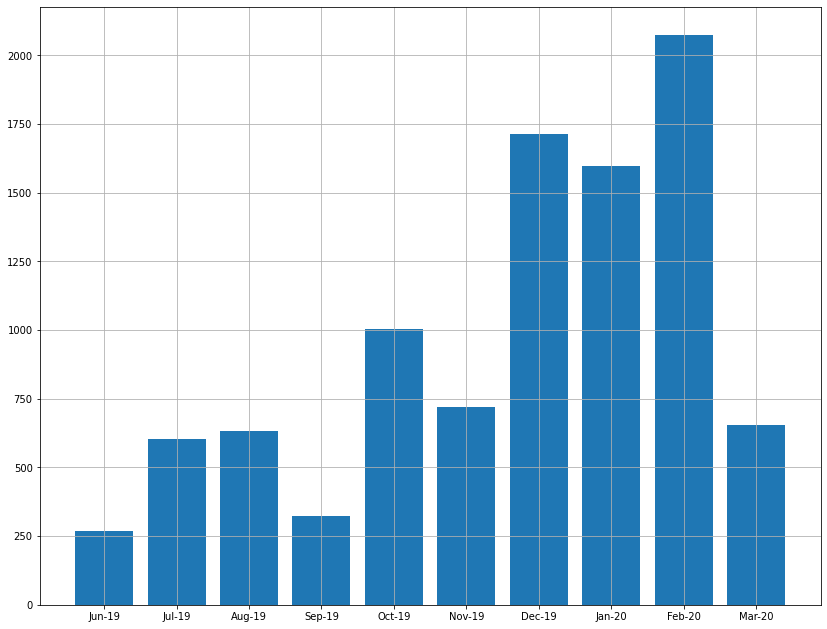

In [12]:
#monthly sums
matplotlib.rcParams['figure.figsize'] = [14,11]
x = trips_df.groupby(trips_df['Date/Time'].dt.to_period("M"))
y = x['Total'].sum()
plt.bar(x=np.arange(len(y.index)),height=y, tick_label=y.index.strftime('%b-%y'))
plt.grid()

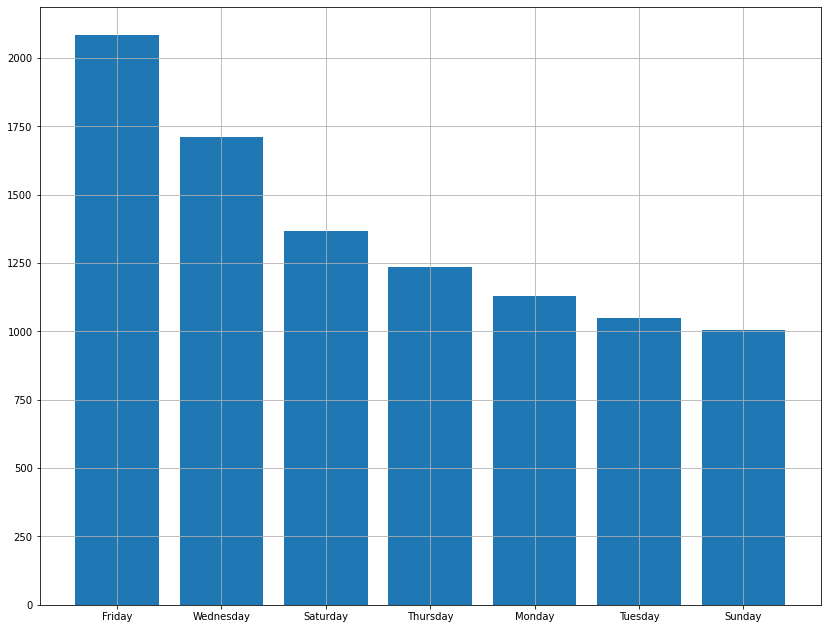

In [13]:
#earnings totals by weekday; 0 = monday
x = trips_df.groupby(trips_df['Date/Time'].dt.day_name(locale='en_US'))
y = x['Total'].sum().sort_values(ascending=False)
plt.bar(x=y.index, height=y)
plt.grid()

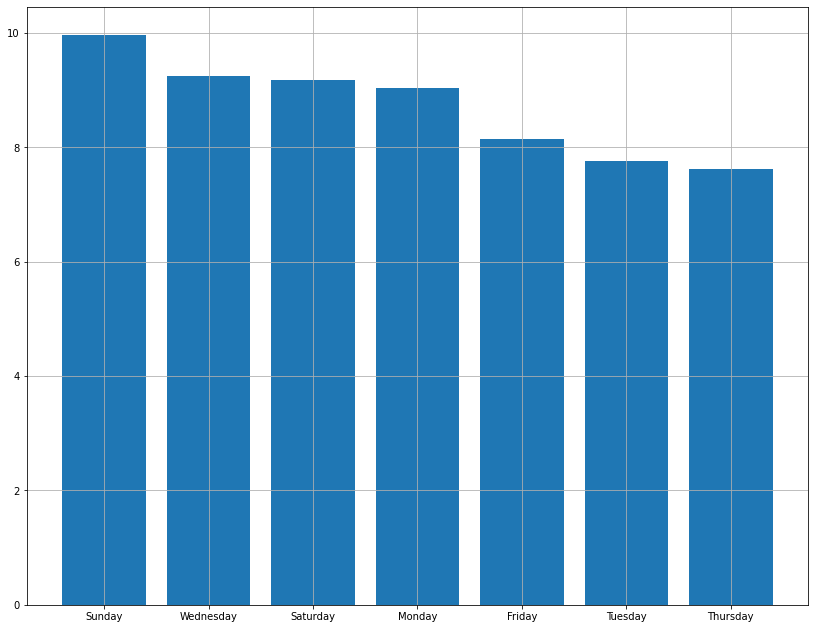

In [14]:
#average trip fare by day
x = trips_df.groupby(trips_df['Date/Time'].dt.day_name(locale='en_US'))
y = x['Total'].mean().sort_values(ascending=False)
plt.bar(x=y.index, height = y)
plt.grid()

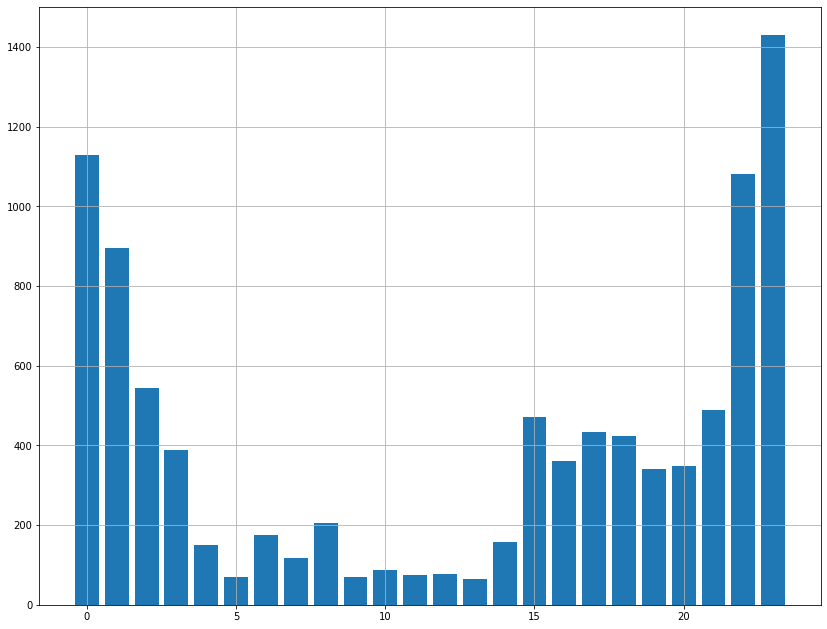

In [15]:
#earnings totals by hour
x = trips_df.groupby(trips_df['Date/Time'].dt.hour)
y = x['Total'].sum()
plt.bar(x=y.index, height=y)
plt.grid()

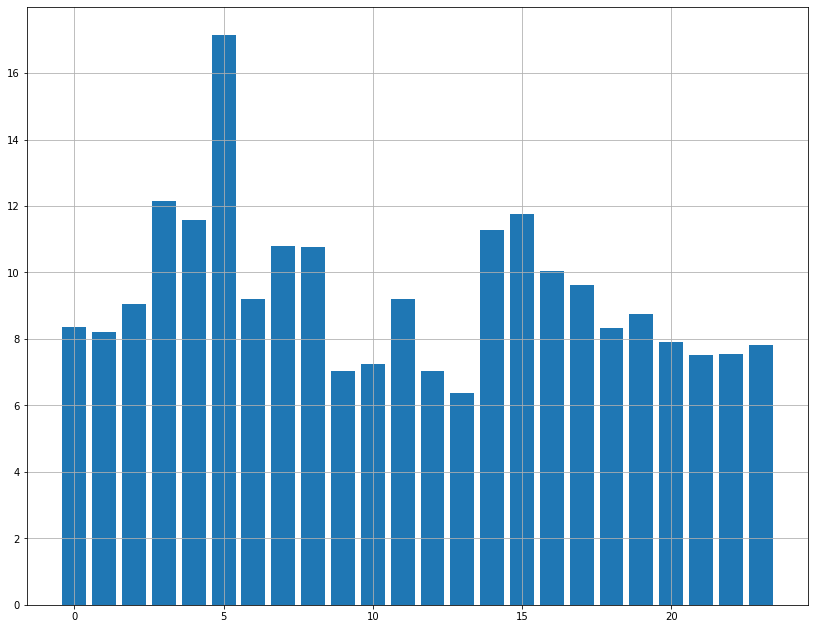

In [16]:
#average trip total by hour
x = trips_df.groupby(trips_df['Date/Time'].dt.hour)
y = x['Total'].mean()
plt.bar(x=y.index, height=y)
plt.grid()

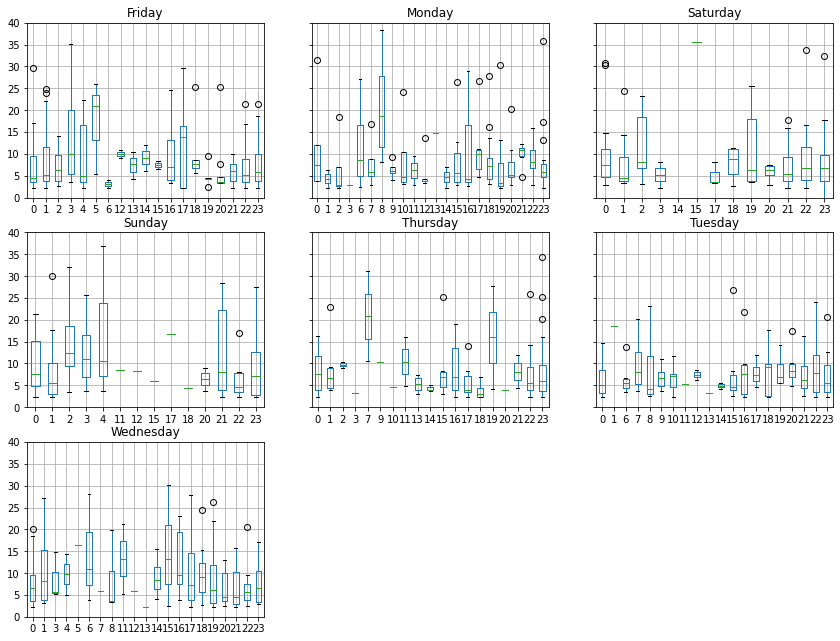

In [17]:
#boxplots of trip fares broken down by weekday, hour
x = trips_df.groupby(trips_df['Date/Time'].dt.day_name(locale='en_US'))
graph = x.boxplot(column='Total', by=trips_df['Date/Time'].dt.hour)
[axis.set_xlabel('') for axis in graph]
plt.suptitle('')
[axis.set_ylim([0,40]) for axis in graph]
plt.show()

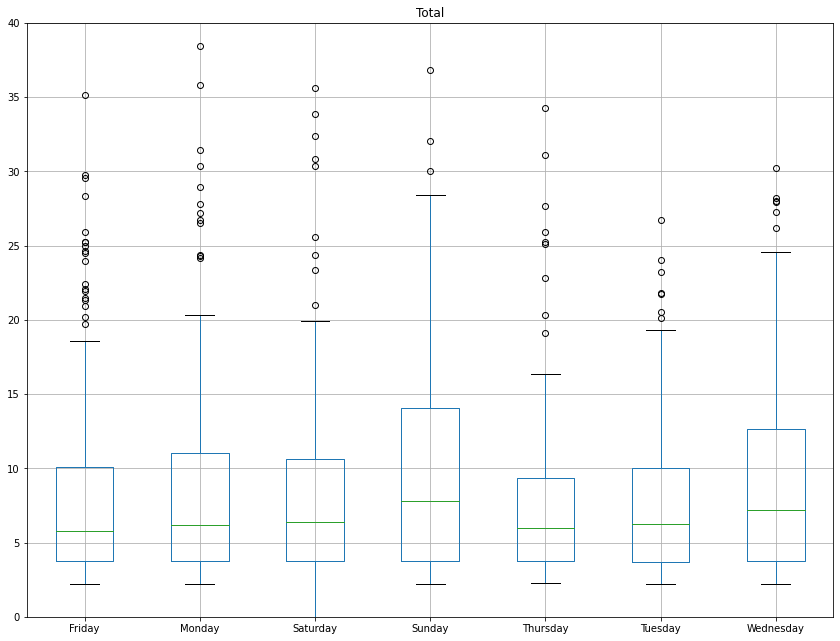

<Figure size 1008x792 with 0 Axes>

In [18]:
#trip fare boxplot by weekday
graph = trips_df.boxplot(column='Total',
                         by=trips_df['Date/Time'].dt.day_name(locale='en_US'),
                         return_type = 'axes')
[axis.set_xlabel('') for axis in graph]
plt.suptitle('')
[axis.set_ylim([0,40]) for axis in graph]
plt.figure()
plt.show()

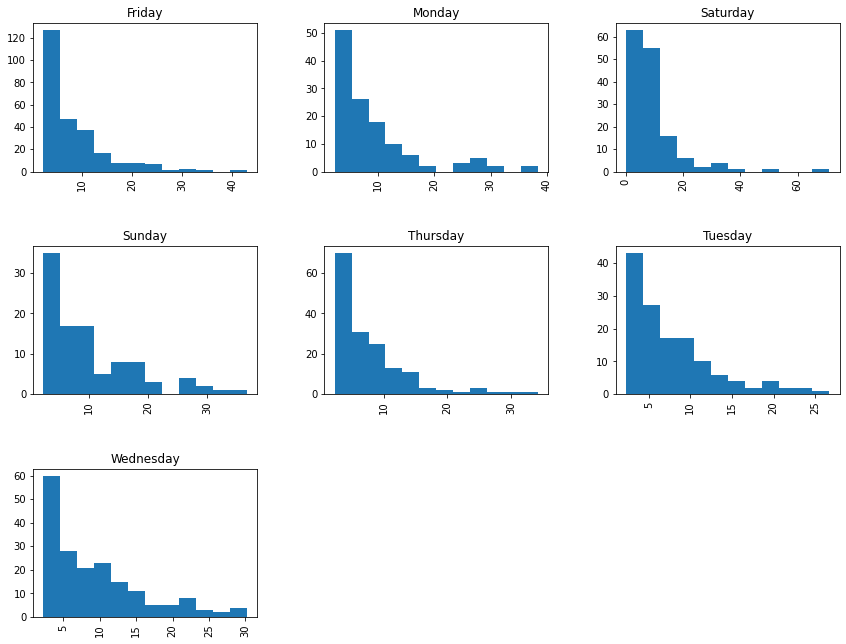

In [19]:
#trip fare histograms by weekday
graph = trips_df['Total'].hist(by=trips_df['Date/Time'].dt.day_name(locale='en_US'),bins=12, grid=True)

In [20]:
#trip type breakdown
trips_df.Type.value_counts()

UberX       1068
Delivery      36
VIP            9
Name: Type, dtype: int64

In [21]:
trips_df.Total.describe()

count    1113.000000
mean        8.608661
std         6.971744
min         0.000000
25%         3.750000
50%         6.300000
75%        10.790000
max        71.110000
Name: Total, dtype: float64

In [22]:
deliveries = trips_df.loc[trips_df.Type == 'Delivery']
deliveries['Total'].describe()

count    36.000000
mean      7.649444
std       3.804756
min       3.640000
25%       4.655000
50%       6.390000
75%       9.057500
max      17.600000
Name: Total, dtype: float64

In [23]:
#total earned from deliveries
round(deliveries.Total.sum(),2)

275.38

In [24]:
cancellations = trips_df.loc[trips_df.Cancellation != 0]
cancellations['Total'].describe()

count    56.000000
mean      3.712500
std       0.550594
min       0.000000
25%       3.750000
50%       3.750000
75%       3.750000
max       5.390000
Name: Total, dtype: float64

In [25]:
#total earned from cancellations
round(cancellations.Total.sum(),2)

207.9

In [26]:
passengers = trips_df.loc[(trips_df['Type'] != 'Delivery') & (trips_df['Cancellation'] == 0.00)]
passengers['Total'].describe()

count    1021.000000
mean        8.911028
std         7.143950
min         2.230000
25%         3.880000
50%         6.850000
75%        11.260000
max        71.110000
Name: Total, dtype: float64

In [27]:
#total earned from passengers
round(passengers.Total.sum(),2)

9098.16

In [28]:
#miles with passenger(s)
miles = passengers.Distance.sum() / 0.6 # 60 cents per mile in Houston, TX
round(miles,1)

8076.9

In [29]:
#percentage of fare from trip distance
round(passengers.Distance.sum() / passengers.Total.sum() * 100,1)

53.3

In [30]:
#avg passenger trip distance in miles
round(miles / len(passengers),1)

7.9

In [31]:
#time with passenger(s) in hours
hours = passengers.Time.sum() / 7.65 # $7.65 per hour in Houston, TX
round(hours,2)

250.67

In [32]:
#percentage of fare from trip duration
round(passengers.Time.sum() / passengers.Total.sum() * 100,1)

21.1

In [33]:
#avg trip duration in minutes
round(60*hours / len(passengers),1)

14.7

In [34]:
#avg speed with passenger in vehicle
round(miles/hours,1)

32.2

In [35]:
#total earned
round(trips_df['Total'].sum(),2)

9581.44

In [36]:
#amount deducted for optional insurance
-1*trips_df['Optional Insurance'].sum()

310.39

In [37]:
#percentage of earnings paid to insurance
round(trips_df['Optional Insurance'].sum() / (trips_df['Total'].sum()-trips_df['Optional Insurance'].sum()) * -100,1)

3.1

In [38]:
#number of passenger trips with an in-app tip
len(passengers.loc[passengers.Tip != 0])

249

In [39]:
#percentage of rides with in-app tip
round(100 * 249 / len(passengers),2)

24.39

In [40]:
#percentage of earnings from tips
round(passengers.Tip.sum() / passengers.Total.sum() * 100,1)

8.3

In [41]:
#total passsenger in-app tips
passengers.Tip.sum()

755.49

In [42]:
#number of deliveries with in-app tip
len(deliveries.loc[deliveries.Tip != 0])

17

In [43]:
#percentage of deliveries with in-app tip
round(100 * len(deliveries.loc[deliveries.Tip != 0]) / len(deliveries),2)

47.22

In [44]:
#total delivery in-app tips
round(deliveries.Tip.sum(),2)

44.06

In [45]:
#avg non-zero delivery in-app tip
round(deliveries.Tip.sum() / len(deliveries.loc[deliveries['Tip'] != 0]),2)

2.59

In [46]:
#avg non-zero passenger in-app tip
round(passengers.Tip.sum() / len(passengers.loc[passengers['Tip'] != 0]),2)

3.03

In [47]:
#largest passenger tip
passengers.Tip.max()

21.86

In [48]:
#tolls reimbursed
passengers.Toll.sum()

285.66

In [49]:
#percentage of earnings paid to toll
round(trips_df.Toll.sum() / trips_df.Total.sum() * 100,1)

3.0

In [50]:
#net passenger earnings = total - tolls
net_earnings = passengers.Total.sum() - passengers.Toll.sum()
net_earnings

8812.5

In [51]:
#avg net earned per passenger trip
round(net_earnings/len(passengers),2)

8.63

In [52]:
#in-app tips as percentage of net passenger earnings
round(100 * (passengers.Tip.sum() / net_earnings),2)

8.57

In [53]:
#approximate hourly earnings with passenger(s) in vehicle
round(net_earnings / 250.67,2)

35.16

In [54]:
#approximate earnings per mile with passenger(s) in vehicle
round(net_earnings / 8076.9,2)

1.09

In [55]:
# of passengers who paid for me to wait on them at pickup and still tipped
len(passengers.loc[(passengers['Wait Time'] != 0) & (passengers.Tip != 0)])

48

In [56]:
# of trips that were so short I got paid a little extra from Uber but they still didn't tip
cheapos = passengers.loc[(passengers['Min Fare Supplement'] != 0) & (passengers.Tip == 0)]
len(cheapos)

82

In [57]:
#% of passengers who are cheapos
round(len(cheapos) / len(passengers) * 100,1)

8.0

In [58]:
#avg distance in miles of cheapo trips
round(cheapos.Distance.mean() / 0.6,1)

0.9

In [59]:
#avg time in minutes of cheapo trips
round(60 * cheapos.Time.mean() / 7.65,1)

3.8

In [60]:
#avg cheapo trip total
round(cheapos.Total.mean(),2)

2.78

In [61]:
#percentage of passengers who ordered minimum fare trips and didn't tip
round(100 * len(cheapos) / len(passengers),1)

8.0

In [62]:
#percentage of passenger earnings from minimum-fare trips where the rider didn't tip
round(100 * cheapos.Total.sum() / passengers.Total.sum(),1)

2.5

In [63]:
#real salt-of-the-earth people who ordered minimum-fare trips, didn't tip, and had me wait on them
jerks = cheapos.loc[cheapos['Wait Time'] != 0]
len(jerks)

21

In [64]:
#lucky for me 4 of these 21 ordered during a surge. Still, though...
jerks.Surge.value_counts()

0.00    17
7.00     1
3.75     1
3.50     1
1.75     1
Name: Surge, dtype: int64

In [65]:
#percentage of passengers that are verified jerks
round(100 * len(jerks) / len(passengers),1)

2.1

In [66]:
#how much I made to drive these jerks around
jerks.Total.sum()

70.06

In [67]:
#how far I drove these jerks in miles
jerks.Distance.sum() / 0.6

20.0

In [68]:
#how much time I spent in the presence of these jerks in hours
round(jerks.Time.sum() / 7.65,2)

1.35

In [69]:
#hourly rate to drive a jerk from a to b. Not bad.
round(70.06/1.35,2)

51.9

In [70]:
#avg speed in mph while driving jerks
round(20/1.35,1)

14.8

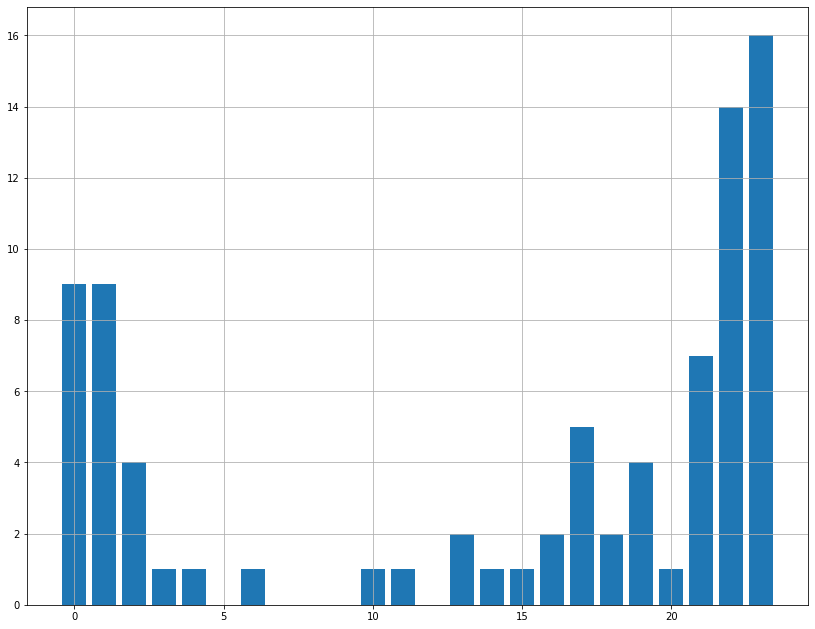

In [71]:
#when do cheapos ride?
x = cheapos.groupby(cheapos['Date/Time'].dt.hour)
y = x['Total'].count()
plt.bar(x=y.index, height = y)
plt.grid()

In [72]:
#surges
surges = passengers.loc[passengers.Surge != 0]
surges.Surge.describe()

count    131.000000
mean       4.675954
std        3.355017
min        1.000000
25%        2.000000
50%        3.860000
75%        6.625000
max       17.360000
Name: Surge, dtype: float64

In [73]:
#total earned from surges, note that I earned less in surges than in tips
surges.Surge.sum()

612.55

In [74]:
#percentage of earnings from surges
round(surges.Surge.sum() / passengers.Total.sum() * 100,1)

6.7

In [75]:
#percentage of trips with surges
round(len(surges) / len(passengers) * 100,1)

12.8

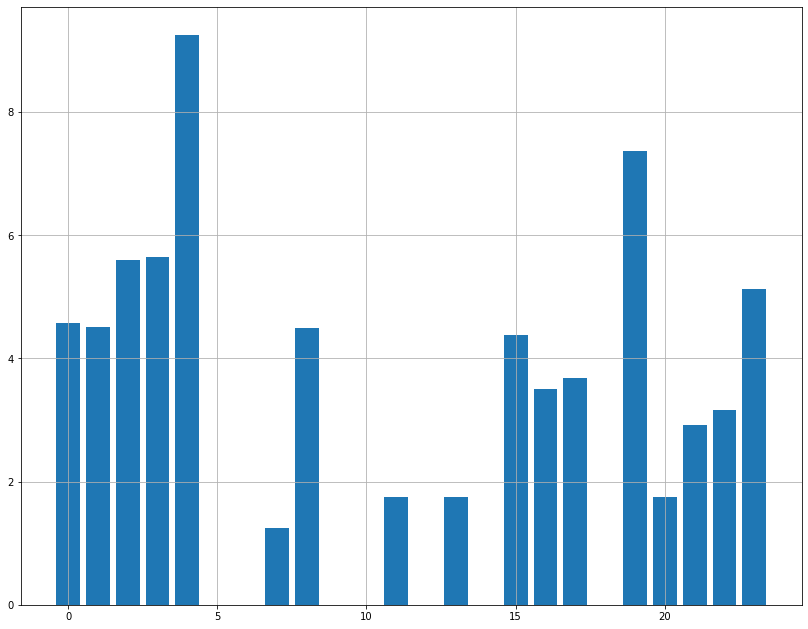

In [76]:
#avg non-zero surge by hour of day 
x = surges.groupby(surges['Date/Time'].dt.hour)
y = x['Surge'].mean()
plt.bar(x=y.index, height = y)
plt.grid()

<BarContainer object of 40 artists>

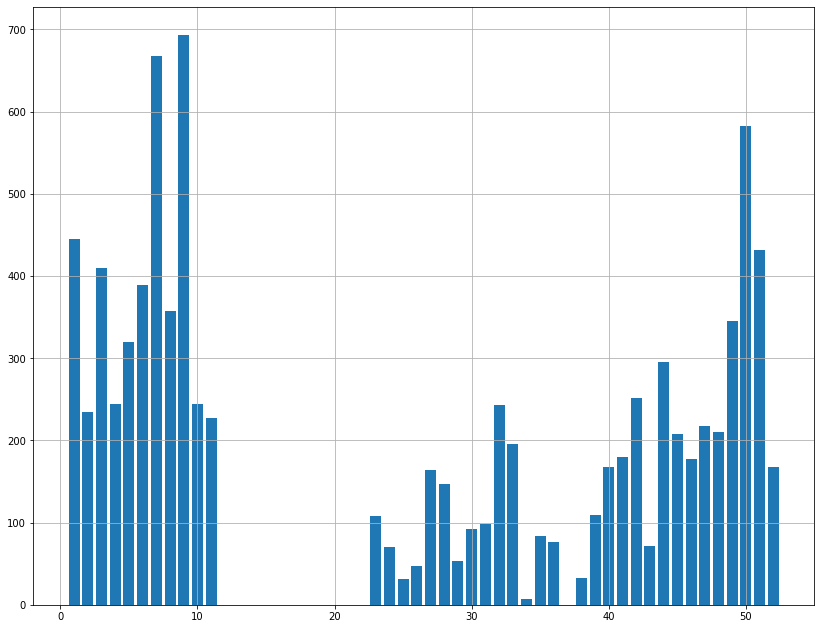

In [77]:
#weekly totals
x = passengers.groupby(passengers['Date/Time'].dt.isocalendar().week)
y = x['Total'].sum()
plt.grid()
plt.bar(x=y.index, height = y)

In [78]:
#pay by week
y.describe()

count     40.000000
mean     227.454000
std      167.787258
min        7.430000
25%       97.180000
50%      201.575000
75%      301.695000
max      692.890000
Name: Total, dtype: float64

In [79]:
#percentage of trips that get cancelled
round(len(cancellations) / len(trips_df) * 100,1)

5.0

In [80]:
longs = passengers.loc[passengers['Long Pickup Fee'] != 0]

In [81]:
#percentage of trips with long pickup
round(len(longs) / len(passengers) * 100,1)

1.2

In [82]:
#long pickup fee means I drove >11 min to pickup. 
#one rider ordered a long pickup, wasn't ready at arrival, and rode ~0.5 mile
#it was a quarter to midnight in Seabrook, about 30 miles from where I wanted to be at the time
#and in case you're wondering, she did indeed say she would tip me in the app
big_jerk = cheapos.loc[cheapos['Long Pickup Fee']!= 0]
big_jerk

,Date/Time,Type,Base Fare,Distance,Time,Min Fare Supplement,Pickup Fee,Dropoff Fee,Tip,Optional Insurance,Total,Toll,Wait Time,Cancellation,Surge,Boost,Long Pickup Fee,Share Adjustment,Fare Adjustment
Trip ID,,,,,,,,,,,,,,,,,,,
4ac185a3-eba0-4723-9179-64da1991f0b3,2020-02-11 23:38:00,UberX,0.75,0.35,0.68,0.2,0.0,0.0,0.0,-0.02,2.54,0.0,0.27,0.0,0.0,0.0,0.31,0.0,0.0


<AxesSubplot:>

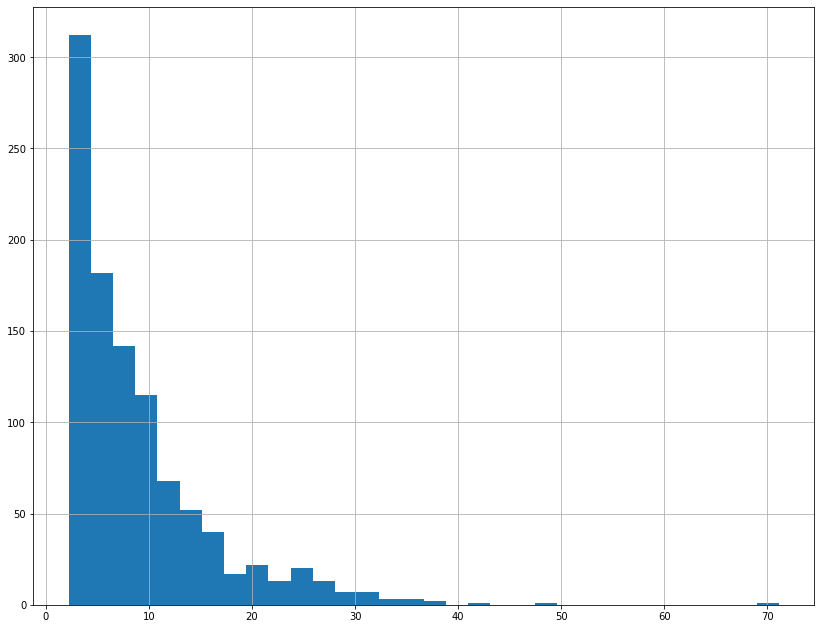

In [83]:
#passenger fare histogram
passengers.Total.hist(bins=32)

In [84]:
winter = trips_df.loc[(trips_df['Date/Time'].dt.month == 1) |
                       (trips_df['Date/Time'].dt.month == 2) |
                       (trips_df['Date/Time'].dt.month == 3) |
                       (trips_df['Date/Time'].dt.month == 12)]

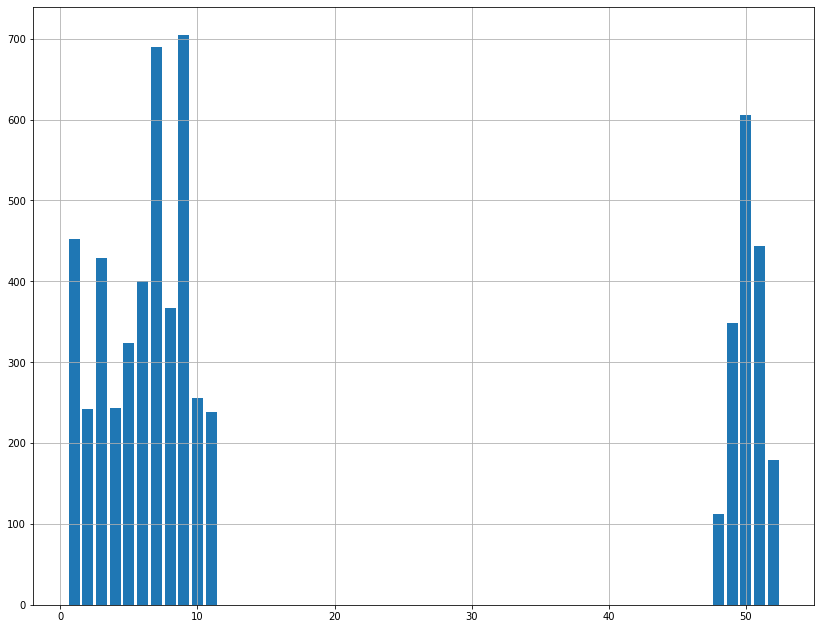

In [85]:
#winter weekly averages
x = winter.groupby(winter['Date/Time'].dt.isocalendar().week)
y = x['Total'].sum()
plt.bar(x=y.index, height = y)
plt.grid()

In [86]:
y.describe()

count     16.000000
mean     377.172500
std      173.850308
min      111.790000
25%      243.582500
50%      357.780000
75%      445.685000
max      704.140000
Name: Total, dtype: float64

In [87]:
#avg earnings per mile on and off trip
round(9581.44/17462,2) #total miles driven while working

0.55

In [88]:
#trip mileage
trips_df.Distance.describe()/.6

count    1855.000000
mean        7.413223
std         8.094579
min         0.000000
25%         2.150000
50%         4.633333
75%        10.050000
max       102.333333
Name: Distance, dtype: float64

In [89]:
#trip duration
trips_df.Time.describe()/7.65*60

count    8729.411765
mean       13.941828
std        10.461780
min         0.000000
25%         7.215686
50%        11.607843
75%        17.725490
max        98.352941
Name: Time, dtype: float64

In [90]:
#theoretical average trip: base fare + median distance + median time
round(.75 + 7.65*11.608/60 + .6*4.633,2)

5.01

In [91]:
#tips
trips_df.loc[trips_df.Tip != 0].Tip.describe()

count    266.000000
mean       3.005827
std        2.199794
min        1.000000
25%        1.000000
50%        3.000000
75%        4.000000
max       21.860000
Name: Tip, dtype: float64

In [92]:
!date

Sat Aug  8 21:22:41 CDT 2020
